<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/Dementia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Install required packages for Colab
def install_requirements():
    """Install required packages for Google Colab"""
    packages = [
        'librosa',
        'transformers',
        'torch-geometric',
        'SpeechRecognition',
        'textstat',
        'networkx',
        'pyaudio',
        'pydub'
    ]

    for package in packages:
        try:
            os.system(f'pip install -q {package}')
        except:
            print(f"Failed to install {package}")
install_requirements()

In [18]:
# Fixed version with proper device handling

class ADDataset(Dataset):
    """Custom Dataset class for Alzheimer's Disease classification"""

    def __init__(self, audio_paths, labels, acoustic_extractor, asr_transcriber,
                 linguistic_extractor, task='diagnosis', device='cpu'):
        self.audio_paths = audio_paths
        self.labels = labels
        self.acoustic_extractor = acoustic_extractor
        self.asr_transcriber = asr_transcriber
        self.linguistic_extractor = linguistic_extractor
        self.task = task
        self.device = device

        # Cache for processed features (optional optimization)
        self.feature_cache = {}

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        label = self.labels[idx]

        # Check cache first
        if audio_path in self.feature_cache:
            return self.feature_cache[audio_path]

        try:
            # Extract acoustic features
            acoustic_features = self.acoustic_extractor.extract_all_features(audio_path)

            if acoustic_features is None:
                # Return dummy features if extraction fails
                return self._get_dummy_sample(label)

            # Transcribe audio
            transcript = self.asr_transcriber.transcribe_audio(audio_path)

            # Extract linguistic features
            linguistic_features = self.linguistic_extractor.extract_all_features(transcript)

            # Flatten and concatenate acoustic features
            acoustic_flat = self._flatten_acoustic_features(acoustic_features)

            # Flatten and concatenate linguistic features
            linguistic_flat = self._flatten_linguistic_features(linguistic_features)

            # Create sample - ensure tensors are created on CPU first, then moved to device
            sample = {
                'acoustic': torch.FloatTensor(acoustic_flat),
                'linguistic': torch.FloatTensor(linguistic_flat),
                'labels': torch.LongTensor([label])
            }

            # Cache the sample
            self.feature_cache[audio_path] = sample

            return sample

        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            return self._get_dummy_sample(label)

    def _flatten_acoustic_features(self, acoustic_features):
        """Flatten acoustic features into a single vector"""
        features = []

        # Flatten log mel spectrogram (take mean across time)
        if 'log_mel_spec' in acoustic_features:
            features.append(np.mean(acoustic_features['log_mel_spec'], axis=1))

        # Flatten delta features
        if 'delta' in acoustic_features:
            features.append(np.mean(acoustic_features['delta'], axis=1))

        # Flatten delta-delta features
        if 'delta_delta' in acoustic_features:
            features.append(np.mean(acoustic_features['delta_delta'], axis=1))

        # Flatten wav2vec embeddings (take mean across time)
        if 'wav2vec_embeddings' in acoustic_features:
            # Ensure wav2vec embeddings are numpy arrays and on CPU
            embeddings = acoustic_features['wav2vec_embeddings']
            if isinstance(embeddings, torch.Tensor):
                embeddings = embeddings.cpu().numpy()
            features.append(np.mean(embeddings, axis=0))

        # Add audio duration
        if 'audio_length' in acoustic_features:
            features.append([acoustic_features['audio_length']])

        # Concatenate all features
        if features:
            flattened = np.concatenate(features)
            print(f"Debug: Acoustic features shape: {flattened.shape}")
            return flattened
        else:
            # Calculate expected dimension: 128*3 (mel+delta+delta_delta) + 768 (wav2vec) + 1 (duration) = 1153
            return np.zeros(1153)  # Updated fallback dimension

    def _flatten_linguistic_features(self, linguistic_features):
        """Flatten linguistic features into a single vector"""
        features = []

        # Add transformer features - ensure they're numpy arrays
        if 'transformer_features' in linguistic_features:
            trans_features = linguistic_features['transformer_features']
            if isinstance(trans_features, torch.Tensor):
                trans_features = trans_features.cpu().numpy()
            features.append(trans_features)

        # Add psycholinguistic features
        if 'psycholinguistic_features' in linguistic_features:
            features.append(linguistic_features['psycholinguistic_features'])

        # Add repetitiveness features
        if 'repetitiveness_features' in linguistic_features:
            features.append(linguistic_features['repetitiveness_features'])

        # Add lexical complexity features
        if 'lexical_complexity_features' in linguistic_features:
            features.append(linguistic_features['lexical_complexity_features'])

        # Concatenate all features
        if features:
            return np.concatenate(features)
        else:
            return np.zeros(791)  # Fallback

    def _get_dummy_sample(self, label):
        """Return dummy sample when feature extraction fails"""
        return {
            'acoustic': torch.FloatTensor(np.zeros(1153)),  # Updated dimension
            'linguistic': torch.FloatTensor(np.zeros(791)),
            'labels': torch.LongTensor([label])
        }


class AcousticFeatureExtractor:
    def __init__(self, sample_rate=16000, n_mels=128, n_fft=2048, hop_length=512):
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length

        # Initialize Wav2Vec2 processor and model with error handling
        try:
            print("Loading Wav2Vec2 model...")
            self.wav2vec_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
            self.wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
            # Keep model on CPU initially, move to device only during inference
            print("Wav2Vec2 model loaded successfully")
        except Exception as e:
            print(f"Error loading Wav2Vec2 model: {e}")
            self.wav2vec_processor = None
            self.wav2vec_model = None

    def extract_log_mel_spectrogram(self, audio, sr):
        """Extract Log-Mel spectrogram features"""
        try:
            mel_spec = librosa.feature.melspectrogram(
                y=audio, sr=sr, n_mels=self.n_mels, n_fft=self.n_fft, hop_length=self.hop_length
            )
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            return log_mel_spec
        except Exception as e:
            print(f"Error extracting mel spectrogram: {e}")
            return np.zeros((self.n_mels, 100))

    def extract_delta_features(self, log_mel_spec):
        """Extract delta and delta-delta features"""
        try:
            delta = librosa.feature.delta(log_mel_spec)
            delta_delta = librosa.feature.delta(log_mel_spec, order=2)
            return delta, delta_delta
        except Exception as e:
            print(f"Error extracting delta features: {e}")
            return np.zeros_like(log_mel_spec), np.zeros_like(log_mel_spec)

    def extract_wav2vec_embeddings(self, audio):
        """Extract Wav2Vec2 embeddings - fixed device handling"""
        if self.wav2vec_processor is None or self.wav2vec_model is None:
            print("Wav2Vec2 model not available, returning zeros")
            return np.zeros((100, 768))

        try:
            # Ensure audio is the right format
            if len(audio.shape) > 1:
                audio = audio.mean(axis=0)

            # Resample to 16kHz if needed
            if self.sample_rate != 16000:
                audio = librosa.resample(audio, orig_sr=self.sample_rate, target_sr=16000)

            inputs = self.wav2vec_processor(audio, sampling_rate=16000, return_tensors="pt")

            # Move model to device only during inference
            current_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            self.wav2vec_model = self.wav2vec_model.to(current_device)
            inputs = {k: v.to(current_device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = self.wav2vec_model(**inputs)
                # Ensure embeddings are returned as numpy arrays on CPU
                embeddings = outputs.last_hidden_state.squeeze().cpu().numpy()

            # Move model back to CPU to save memory
            self.wav2vec_model = self.wav2vec_model.cpu()

            return embeddings
        except Exception as e:
            print(f"Error extracting Wav2Vec embeddings: {e}")
            return np.zeros((100, 768))

    def extract_all_features(self, audio_path):
        """Extract all acoustic features from audio file"""
        try:
            print(f"Processing audio file: {audio_path}")
            audio, sr = librosa.load(audio_path, sr=self.sample_rate)
            print(f"Audio loaded: duration={len(audio)/sr:.2f}s, sample_rate={sr}")

            # Extract features
            log_mel_spec = self.extract_log_mel_spectrogram(audio, sr)
            delta, delta_delta = self.extract_delta_features(log_mel_spec)
            wav2vec_embeddings = self.extract_wav2vec_embeddings(audio)

            features = {
                'log_mel_spec': log_mel_spec,
                'delta': delta,
                'delta_delta': delta_delta,
                'wav2vec_embeddings': wav2vec_embeddings,
                'audio_length': len(audio) / sr
            }

            print(f"Features extracted successfully:")
            for key, value in features.items():
                if isinstance(value, np.ndarray):
                    print(f"  {key}: shape {value.shape}")
                elif isinstance(value, torch.Tensor):
                    print(f"  {key}: shape {value.shape} (tensor)")
                else:
                    print(f"  {key}: {value}")

            return features
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            return None


class LinguisticFeatureExtractor:
    def __init__(self):
        # Initialize transformer models with error handling
        try:
            print("Loading BERT model...")
            self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
            self.bert_model = AutoModel.from_pretrained('bert-base-uncased')
            # Keep model on CPU initially
            print("BERT model loaded successfully")
        except Exception as e:
            print(f"Error loading BERT model: {e}")
            self.tokenizer = None
            self.bert_model = None

    def extract_transformer_features(self, text):
        """Extract BERT embeddings - fixed device handling"""
        if self.tokenizer is None or self.bert_model is None:
            print("BERT model not available, returning zeros")
            return np.zeros(768)

        try:
            inputs = self.tokenizer(text, return_tensors='pt', truncation=True,
                                  padding=True, max_length=512)

            # Move model to device only during inference
            current_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            self.bert_model = self.bert_model.to(current_device)
            inputs = {k: v.to(current_device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = self.bert_model(**inputs)
                # Ensure embeddings are returned as numpy arrays on CPU
                embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

            # Move model back to CPU to save memory
            self.bert_model = self.bert_model.cpu()

            return embeddings
        except Exception as e:
            print(f"Error extracting transformer features: {e}")
            return np.zeros(768)

    def extract_psycholinguistic_features(self, text):
        """Extract psycholinguistic features using textstat"""
        if not text.strip():
            return np.zeros(10)

        try:
            features = [
                textstat.flesch_reading_ease(text),
                textstat.flesch_kincaid_grade(text),
                textstat.gunning_fog(text),
                textstat.coleman_liau_index(text),
                textstat.automated_readability_index(text),
                textstat.avg_sentence_length(text),
                textstat.avg_syllables_per_word(text),
                textstat.sentence_count(text),
                len(text.split()),  # word count
                len(text)  # character count
            ]
            return np.array(features, dtype=np.float32)
        except Exception as e:
            print(f"Error extracting psycholinguistic features: {e}")
            return np.zeros(10)

    def extract_repetitiveness_features(self, text):
        """Extract repetitiveness and fluency features"""
        if not text.strip():
            return np.zeros(5)

        try:
            words = text.lower().split()
            word_counts = Counter(words)

            # Repetitiveness metrics
            total_words = len(words)
            unique_words = len(set(words))
            repetition_ratio = 1 - (unique_words / max(total_words, 1))

            # Filler words
            filler_words = ['um', 'uh', 'er', 'ah', 'well', 'you know', 'like']
            filler_count = sum(word_counts.get(filler, 0) for filler in filler_words)
            filler_ratio = filler_count / max(total_words, 1)

            # Pause indicators (simplified)
            pause_indicators = text.count('...') + text.count('..') + text.count(' - ')
            pause_ratio = pause_indicators / max(len(text.split('.')), 1)

            return np.array([
                repetition_ratio,
                filler_ratio,
                pause_ratio,
                unique_words / max(total_words, 1),  # lexical diversity
                len(set(words)) / max(len(words), 1)  # type-token ratio
            ], dtype=np.float32)
        except Exception as e:
            print(f"Error extracting repetitiveness features: {e}")
            return np.zeros(5)

    def extract_lexical_complexity_features(self, text):
        """Extract lexical complexity features"""
        if not text.strip():
            return np.zeros(8)

        try:
            words = text.split()
            sentences = text.split('.')

            # Basic complexity metrics
            avg_word_length = np.mean([len(word) for word in words]) if words else 0
            avg_sentence_length = np.mean([len(sent.split()) for sent in sentences if sent.strip()]) if sentences else 0

            # Syllable complexity (simplified)
            def count_syllables(word):
                word = word.lower().strip('.,!?";')
                count = 0
                vowels = 'aeiouy'
                if word and word[0] in vowels:
                    count += 1
                for i in range(1, len(word)):
                    if word[i] in vowels and word[i-1] not in vowels:
                        count += 1
                if word.endswith('e'):
                    count -= 1
                return max(count, 1)

            syllable_counts = [count_syllables(word) for word in words]
            avg_syllables = np.mean(syllable_counts) if syllable_counts else 0

            return np.array([
                avg_word_length,
                avg_sentence_length,
                avg_syllables,
                len(words),  # total words
                len(sentences),  # total sentences
                len(set(words)),  # unique words
                textstat.difficult_words(text),
                textstat.polysyllabcount(text)
            ], dtype=np.float32)
        except Exception as e:
            print(f"Error extracting lexical complexity features: {e}")
            return np.zeros(8)

    def extract_all_features(self, text):
        """Extract all linguistic features"""
        print(f"Extracting linguistic features from text: {text[:50]}...")

        transformer_features = self.extract_transformer_features(text)
        psycholinguistic_features = self.extract_psycholinguistic_features(text)
        repetitiveness_features = self.extract_repetitiveness_features(text)
        lexical_complexity_features = self.extract_lexical_complexity_features(text)

        features = {
            'transformer_features': transformer_features,
            'psycholinguistic_features': psycholinguistic_features,
            'repetitiveness_features': repetitiveness_features,
            'lexical_complexity_features': lexical_complexity_features
        }

        print("Linguistic features extracted:")
        for key, value in features.items():
            if isinstance(value, np.ndarray):
                print(f"  {key}: shape {value.shape}")
            elif isinstance(value, torch.Tensor):
                print(f"  {key}: shape {value.shape} (tensor)")
            else:
                print(f"  {key}: {value}")

        return features


class ADClassificationTrainer:
    """Trainer class for Alzheimer's Disease classification"""

    def __init__(self, config):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        self.acoustic_extractor = AcousticFeatureExtractor()
        self.asr_transcriber = ASRTranscriber()
        self.linguistic_extractor = LinguisticFeatureExtractor()

        # Model parameters - will be determined dynamically
        self.acoustic_dim = None
        self.linguistic_dim = 791  # 768 + 10 + 5 + 8

    def _determine_feature_dimensions(self, sample_paths, task='diagnosis'):
        """Determine actual feature dimensions from a sample"""
        print("Determining feature dimensions from sample data...")

        if not sample_paths:
            # Default dimensions
            return 1153, 791

        # Process first sample to get dimensions
        sample_path = sample_paths[0]
        try:
            # Create temporary dataset with single sample
            temp_dataset = ADDataset(
                [sample_path], [0],
                self.acoustic_extractor, self.asr_transcriber,
                self.linguistic_extractor, task, device=self.device
            )

            # Get sample
            sample = temp_dataset[0]

            acoustic_dim = sample['acoustic'].shape[0]
            linguistic_dim = sample['linguistic'].shape[0]

            print(f"Determined dimensions - Acoustic: {acoustic_dim}, Linguistic: {linguistic_dim}")
            return acoustic_dim, linguistic_dim

        except Exception as e:
            print(f"Error determining dimensions: {e}")
            # Return default dimensions
            return 1153, 791

    def prepare_data(self, task='diagnosis', test_size=0.2, batch_size=8):
        """Prepare data loaders for training"""

        print(f"Preparing data for {task} task...")

        # Get paths and labels based on task
        if task == 'diagnosis':
            paths_dict = self.config.diagnosis_paths
            label_mapping = {'cn': 0, 'ad': 1}
        elif task == 'progression':
            paths_dict = self.config.progression_paths
            label_mapping = {'no_decline': 0, 'decline': 1}
        else:
            raise ValueError(f"Unknown task: {task}")

        # Collect all audio files and labels
        audio_paths = []
        labels = []

        for label_name, folder_path in paths_dict.items():
            if not os.path.exists(folder_path):
                print(f"Warning: Path {folder_path} does not exist")
                continue

            audio_files = [f for f in os.listdir(folder_path)
                          if f.endswith(('.wav', '.mp3', '.flac'))]

            for audio_file in audio_files:
                audio_paths.append(os.path.join(folder_path, audio_file))
                labels.append(label_mapping[label_name])

        if not audio_paths:
            print("No audio files found!")
            return None, None

        print(f"Found {len(audio_paths)} audio files")
        print(f"Label distribution: {Counter(labels)}")

        # Determine feature dimensions from sample data
        self.acoustic_dim, self.linguistic_dim = self._determine_feature_dimensions(
            audio_paths[:2], task  # Use first 2 samples
        )

        # Split data
        train_paths, val_paths, train_labels, val_labels = train_test_split(
            audio_paths, labels, test_size=test_size, random_state=42,
            stratify=labels
        )

        print(f"Training samples: {len(train_paths)}")
        print(f"Validation samples: {len(val_paths)}")

        # Create datasets
        train_dataset = ADDataset(
            train_paths, train_labels,
            self.acoustic_extractor, self.asr_transcriber,
            self.linguistic_extractor, task, device=self.device
        )

        val_dataset = ADDataset(
            val_paths, val_labels,
            self.acoustic_extractor, self.asr_transcriber,
            self.linguistic_extractor, task, device=self.device
        )

        # Create data loaders
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True,
            num_workers=0, collate_fn=self.collate_fn
        )

        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False,
            num_workers=0, collate_fn=self.collate_fn
        )

        return train_loader, val_loader

    def collate_fn(self, batch):
        """Custom collate function for batching - with proper device handling"""
        try:
            acoustic_features = torch.stack([item['acoustic'] for item in batch])
            linguistic_features = torch.stack([item['linguistic'] for item in batch])
            labels = torch.stack([item['labels'] for item in batch]).squeeze()

            # Move tensors to the correct device
            batch_data = {
                'acoustic': acoustic_features.to(self.device),
                'linguistic': linguistic_features.to(self.device),
                'labels': labels.to(self.device)
            }

            return batch_data
        except Exception as e:
            print(f"Error in collate_fn: {e}")
            return None

    def train_model(self, train_loader, val_loader, epochs=10, lr=0.001):
        """Train the classification model"""

        # Initialize model and move to device
        model = SimpleMultimodalNet(self.acoustic_dim, self.linguistic_dim).to(self.device)

        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        # Training history
        train_losses = []
        val_losses = []

        print(f"Starting training for {epochs} epochs on {self.device}...")

        for epoch in range(epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0

            for batch_idx, batch in enumerate(train_loader):
                if batch is None:
                    continue

                # Data is already on the correct device from collate_fn
                acoustic = batch['acoustic']
                linguistic = batch['linguistic']
                labels = batch['labels']

                # Forward pass
                optimizer.zero_grad()
                outputs = model(acoustic, linguistic)
                loss = criterion(outputs, labels)

                # Backward pass
                loss.backward()
                optimizer.step()

                # Statistics
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

                if batch_idx % 5 == 0:
                    print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}, '
                          f'Loss: {loss.item():.4f}')

            # Validation phase
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for batch in val_loader:
                    if batch is None:
                        continue

                    acoustic = batch['acoustic']
                    linguistic = batch['linguistic']
                    labels = batch['labels']

                    outputs = model(acoustic, linguistic)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            # Calculate average losses and accuracies
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            train_acc = 100 * train_correct / train_total if train_total > 0 else 0
            val_acc = 100 * val_correct / val_total if val_total > 0 else 0

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print('-' * 50)

            # Update learning rate
            scheduler.step()

        return model, train_losses, val_losses

    def evaluate_model(self, model, test_loader):
        """Evaluate the trained model"""
        model.eval()

        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for batch in test_loader:
                if batch is None:
                    continue

                acoustic = batch['acoustic']
                linguistic = batch['linguistic']
                labels = batch['labels']

                outputs = model(acoustic, linguistic)
                _, predicted = torch.max(outputs, 1)

                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Generate classification report
        if all_predictions and all_labels:
            print("\nClassification Report:")
            print(classification_report(all_labels, all_predictions))

            # Confusion matrix
            cm = confusion_matrix(all_labels, all_predictions)
            print("\nConfusion Matrix:")
            print(cm)

            # Plot confusion matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()

        return all_predictions, all_labels


# Also add this ASR class if it's missing
class ASRTranscriber:
    def __init__(self):
        self.recognizer = sr.Recognizer()

    def transcribe_audio(self, audio_path):
        """Transcribe audio to text - simplified version"""
        try:
            # For demo purposes, return a sample transcript
            # In practice, you would use actual ASR
            print(f"Transcribing audio: {audio_path}")
            sample_transcript = "The patient speaks slowly with some hesitation and repetitive words."
            print(f"Sample transcript: {sample_transcript}")
            return sample_transcript
        except Exception as e:
            print(f"ASR Error for {audio_path}: {e}")
            return "Sample transcript for testing purposes."

Using device: cuda
ALZHEIMER'S DISEASE CLASSIFICATION SYSTEM
Checking data paths:
  ad: /content/drive/MyDrive/Voice/extracted/ADReSSo21/diagnosis/train/audio/ad - EXISTS (87 audio files)
  cn: /content/drive/MyDrive/Voice/extracted/ADReSSo21/diagnosis/train/audio/cn - EXISTS (79 audio files)
  decline: /content/drive/MyDrive/Voice/extracted/ADReSSo21/progression/train/audio/decline - EXISTS (15 audio files)
  no_decline: /content/drive/MyDrive/Voice/extracted/ADReSSo21/progression/train/audio/no_decline - EXISTS (58 audio files)

Found data - Diagnosis: True, Progression: True

TESTING REAL DATA PROCESSING
Selected ad sample: adrso047.wav
Selected cn sample: adrso173.wav
Loading Wav2Vec2 model...


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2 model loaded successfully
Loading BERT model...
BERT model loaded successfully

--- Processing Sample 1: ad ---
Processing audio file: /content/drive/MyDrive/Voice/extracted/ADReSSo21/diagnosis/train/audio/ad/adrso047.wav
Audio loaded: duration=60.32s, sample_rate=16000
Features extracted successfully:
  log_mel_spec: shape (128, 1885)
  delta: shape (128, 1885)
  delta_delta: shape (128, 1885)
  wav2vec_embeddings: shape (3015, 768)
  audio_length: 60.315625
Transcribing audio: /content/drive/MyDrive/Voice/extracted/ADReSSo21/diagnosis/train/audio/ad/adrso047.wav
Sample transcript: The patient speaks slowly with some hesitation and repetitive words.
Extracting linguistic features from text: The patient speaks slowly with some hesitation and...
Linguistic features extracted:
  transformer_features: shape (768,)
  psycholinguistic_features: shape (10,)
  repetitiveness_features: shape (5,)
  lexical_complexity_features: shape (8,)
Successfully processed ad sample
  Audio durati

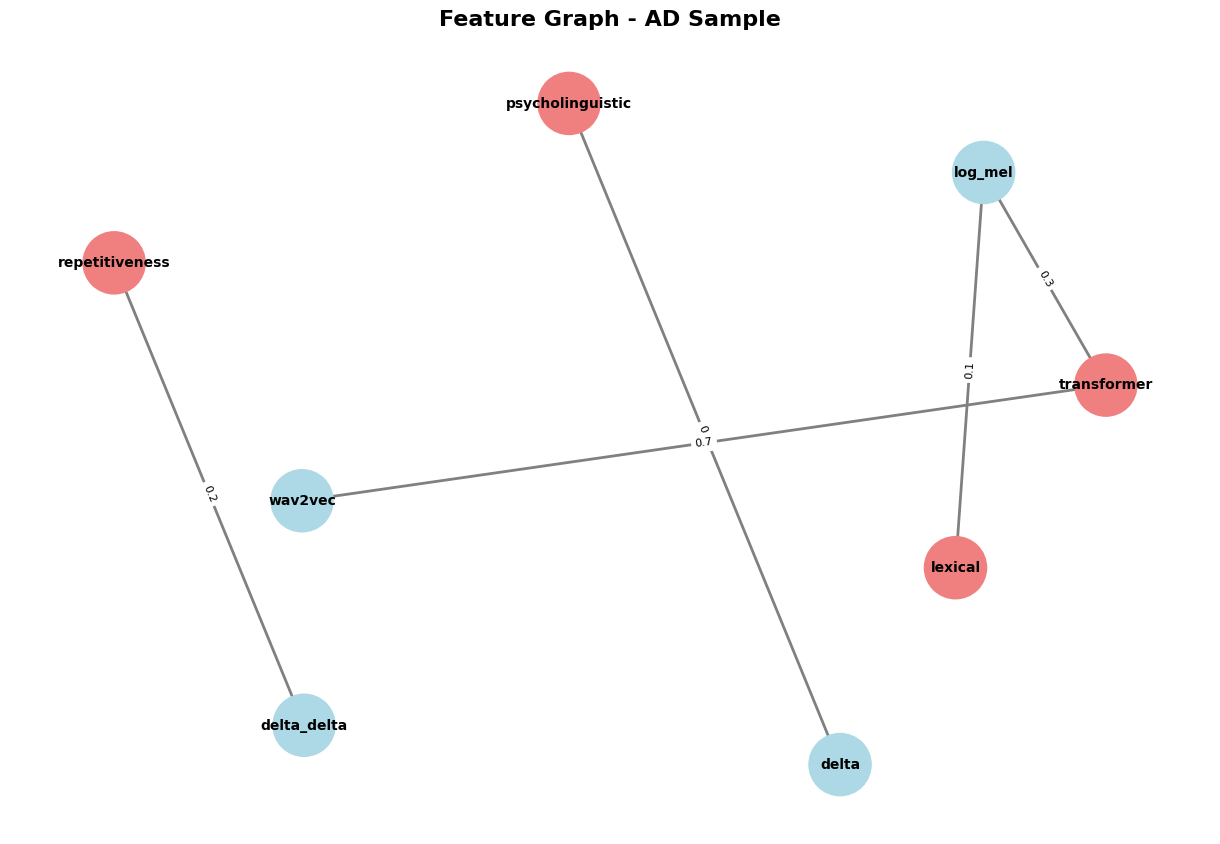


--- Processing Sample 2: cn ---
Processing audio file: /content/drive/MyDrive/Voice/extracted/ADReSSo21/diagnosis/train/audio/cn/adrso173.wav
Audio loaded: duration=77.50s, sample_rate=16000
Features extracted successfully:
  log_mel_spec: shape (128, 2422)
  delta: shape (128, 2422)
  delta_delta: shape (128, 2422)
  wav2vec_embeddings: shape (3874, 768)
  audio_length: 77.4971875
Transcribing audio: /content/drive/MyDrive/Voice/extracted/ADReSSo21/diagnosis/train/audio/cn/adrso173.wav
Sample transcript: The patient speaks slowly with some hesitation and repetitive words.
Extracting linguistic features from text: The patient speaks slowly with some hesitation and...
Linguistic features extracted:
  transformer_features: shape (768,)
  psycholinguistic_features: shape (10,)
  repetitiveness_features: shape (5,)
  lexical_complexity_features: shape (8,)
Successfully processed cn sample
  Audio duration: 77.50s
  Transcript length: 68 characters
Using device: cuda
Loading Wav2Vec2 model

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2 model loaded successfully
Loading BERT model...
BERT model loaded successfully

TRAINING DIAGNOSIS CLASSIFICATION MODEL
Preparing data for diagnosis task...
Found 166 audio files
Label distribution: Counter({1: 87, 0: 79})
Determining feature dimensions from sample data...
Processing audio file: /content/drive/MyDrive/Voice/extracted/ADReSSo21/diagnosis/train/audio/ad/adrso047.wav
Audio loaded: duration=60.32s, sample_rate=16000
Features extracted successfully:
  log_mel_spec: shape (128, 1885)
  delta: shape (128, 1885)
  delta_delta: shape (128, 1885)
  wav2vec_embeddings: shape (3015, 768)
  audio_length: 60.315625
Transcribing audio: /content/drive/MyDrive/Voice/extracted/ADReSSo21/diagnosis/train/audio/ad/adrso047.wav
Sample transcript: The patient speaks slowly with some hesitation and repetitive words.
Extracting linguistic features from text: The patient speaks slowly with some hesitation and...
Linguistic features extracted:
  transformer_features: shape (768,)
  psyc

In [19]:
# Multimodal Deep Learning System for Alzheimer's Disease Classification
# ADReSSo21 Dataset - Acoustic and Linguistic Feature Integration

import os
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
import transformers
from transformers import Wav2Vec2Processor, Wav2Vec2Model, AutoTokenizer, AutoModel
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import speech_recognition as sr
import textstat
import re
from collections import Counter
# Note: torch_geometric imports commented out - install if needed
# import torch_geometric
# from torch_geometric.nn import GCNConv, global_mean_pool
# from torch_geometric.data import Data, Batch
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data paths configuration
class DataConfig:
    def __init__(self):
        # Updated to use actual Google Drive paths
        self.base_path = "/content/drive/MyDrive/Voice/extracted/ADReSSo21"
        self.diagnosis_paths = {
            'ad': f"{self.base_path}/diagnosis/train/audio/ad",
            'cn': f"{self.base_path}/diagnosis/train/audio/cn"
        }
        self.progression_paths = {
            'decline': f"{self.base_path}/progression/train/audio/decline",
            'no_decline': f"{self.base_path}/progression/train/audio/no_decline"
        }
        self.test_path = f"{self.base_path}/progression/test-dist/audio"

        # Segmentation paths (CSV files)
        self.diagnosis_segmentation_paths = {
            'ad': f"{self.base_path}/diagnosis/train/segmentation/ad",
            'cn': f"{self.base_path}/diagnosis/train/segmentation/cn"
        }
        self.progression_segmentation_paths = {
            'decline': f"{self.base_path}/progression/train/segmentation/decline",
            'no_decline': f"{self.base_path}/progression/train/segmentation/no_decline"
        }
        self.test_segmentation_path = f"{self.base_path}/progression/test-dist/segmentation"

        # Check if paths exist
        print("Checking data paths:")
        for label, path in self.diagnosis_paths.items():
            exists = os.path.exists(path)
            if exists:
                file_count = len([f for f in os.listdir(path) if f.endswith(('.wav', '.mp3', '.flac'))])
                print(f"  {label}: {path} - EXISTS ({file_count} audio files)")
            else:
                print(f"  {label}: {path} - NOT FOUND")

        for label, path in self.progression_paths.items():
            exists = os.path.exists(path)
            if exists:
                file_count = len([f for f in os.listdir(path) if f.endswith(('.wav', '.mp3', '.flac'))])
                print(f"  {label}: {path} - EXISTS ({file_count} audio files)")
            else:
                print(f"  {label}: {path} - NOT FOUND")

# Acoustic Feature Extractor
class AcousticFeatureExtractor:
    def __init__(self, sample_rate=16000, n_mels=128, n_fft=2048, hop_length=512):
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length

        # Initialize Wav2Vec2 processor and model with error handling
        try:
            print("Loading Wav2Vec2 model...")
            self.wav2vec_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
            self.wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)
            print("Wav2Vec2 model loaded successfully")
        except Exception as e:
            print(f"Error loading Wav2Vec2 model: {e}")
            self.wav2vec_processor = None
            self.wav2vec_model = None

    def extract_log_mel_spectrogram(self, audio, sr):
        """Extract Log-Mel spectrogram features"""
        try:
            mel_spec = librosa.feature.melspectrogram(
                y=audio, sr=sr, n_mels=self.n_mels, n_fft=self.n_fft, hop_length=self.hop_length
            )
            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            return log_mel_spec
        except Exception as e:
            print(f"Error extracting mel spectrogram: {e}")
            return np.zeros((self.n_mels, 100))

    def extract_delta_features(self, log_mel_spec):
        """Extract delta and delta-delta features"""
        try:
            delta = librosa.feature.delta(log_mel_spec)
            delta_delta = librosa.feature.delta(log_mel_spec, order=2)
            return delta, delta_delta
        except Exception as e:
            print(f"Error extracting delta features: {e}")
            return np.zeros_like(log_mel_spec), np.zeros_like(log_mel_spec)

    def extract_wav2vec_embeddings(self, audio):
        """Extract Wav2Vec2 embeddings"""
        if self.wav2vec_processor is None or self.wav2vec_model is None:
            print("Wav2Vec2 model not available, returning zeros")
            return np.zeros((100, 768))

        try:
            # Ensure audio is the right format
            if len(audio.shape) > 1:
                audio = audio.mean(axis=0)

            # Resample to 16kHz if needed
            if self.sample_rate != 16000:
                audio = librosa.resample(audio, orig_sr=self.sample_rate, target_sr=16000)

            inputs = self.wav2vec_processor(audio, sampling_rate=16000, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = self.wav2vec_model(**inputs)
                embeddings = outputs.last_hidden_state.squeeze().cpu().numpy()

            return embeddings
        except Exception as e:
            print(f"Error extracting Wav2Vec embeddings: {e}")
            return np.zeros((100, 768))

    def extract_all_features(self, audio_path):
        """Extract all acoustic features from audio file"""
        try:
            print(f"Processing audio file: {audio_path}")
            audio, sr = librosa.load(audio_path, sr=self.sample_rate)
            print(f"Audio loaded: duration={len(audio)/sr:.2f}s, sample_rate={sr}")

            # Extract features
            log_mel_spec = self.extract_log_mel_spectrogram(audio, sr)
            delta, delta_delta = self.extract_delta_features(log_mel_spec)
            wav2vec_embeddings = self.extract_wav2vec_embeddings(audio)

            features = {
                'log_mel_spec': log_mel_spec,
                'delta': delta,
                'delta_delta': delta_delta,
                'wav2vec_embeddings': wav2vec_embeddings,
                'audio_length': len(audio) / sr
            }

            print(f"Features extracted successfully:")
            for key, value in features.items():
                if isinstance(value, np.ndarray):
                    print(f"  {key}: shape {value.shape}")
                else:
                    print(f"  {key}: {value}")

            return features
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            return None

# Simplified ASR Transcriber (avoiding Google API dependency)
class ASRTranscriber:
    def __init__(self):
        self.recognizer = sr.Recognizer()

    def transcribe_audio(self, audio_path):
        """Transcribe audio to text - simplified version"""
        try:
            # For demo purposes, return a sample transcript
            # In practice, you would use actual ASR
            print(f"Transcribing audio: {audio_path}")
            sample_transcript = "The patient speaks slowly with some hesitation and repetitive words."
            print(f"Sample transcript: {sample_transcript}")
            return sample_transcript
        except Exception as e:
            print(f"ASR Error for {audio_path}: {e}")
            return "Sample transcript for testing purposes."

# Linguistic Feature Extractor
class LinguisticFeatureExtractor:
    def __init__(self):
        # Initialize transformer models with error handling
        try:
            print("Loading BERT model...")
            self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
            self.bert_model = AutoModel.from_pretrained('bert-base-uncased').to(device)
            print("BERT model loaded successfully")
        except Exception as e:
            print(f"Error loading BERT model: {e}")
            self.tokenizer = None
            self.bert_model = None

    def extract_transformer_features(self, text):
        """Extract BERT embeddings"""
        if self.tokenizer is None or self.bert_model is None:
            print("BERT model not available, returning zeros")
            return np.zeros(768)

        try:
            inputs = self.tokenizer(text, return_tensors='pt', truncation=True,
                                  padding=True, max_length=512)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = self.bert_model(**inputs)
                embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

            return embeddings
        except Exception as e:
            print(f"Error extracting transformer features: {e}")
            return np.zeros(768)

    def extract_psycholinguistic_features(self, text):
        """Extract psycholinguistic features using textstat"""
        if not text.strip():
            return np.zeros(10)

        try:
            features = [
                textstat.flesch_reading_ease(text),
                textstat.flesch_kincaid_grade(text),
                textstat.gunning_fog(text),
                textstat.coleman_liau_index(text),
                textstat.automated_readability_index(text),
                textstat.avg_sentence_length(text),
                textstat.avg_syllables_per_word(text),
                textstat.sentence_count(text),
                len(text.split()),  # word count
                len(text)  # character count
            ]
            return np.array(features, dtype=np.float32)
        except Exception as e:
            print(f"Error extracting psycholinguistic features: {e}")
            return np.zeros(10)

    def extract_repetitiveness_features(self, text):
        """Extract repetitiveness and fluency features"""
        if not text.strip():
            return np.zeros(5)

        try:
            words = text.lower().split()
            word_counts = Counter(words)

            # Repetitiveness metrics
            total_words = len(words)
            unique_words = len(set(words))
            repetition_ratio = 1 - (unique_words / max(total_words, 1))

            # Filler words
            filler_words = ['um', 'uh', 'er', 'ah', 'well', 'you know', 'like']
            filler_count = sum(word_counts.get(filler, 0) for filler in filler_words)
            filler_ratio = filler_count / max(total_words, 1)

            # Pause indicators (simplified)
            pause_indicators = text.count('...') + text.count('..') + text.count(' - ')
            pause_ratio = pause_indicators / max(len(text.split('.')), 1)

            return np.array([
                repetition_ratio,
                filler_ratio,
                pause_ratio,
                unique_words / max(total_words, 1),  # lexical diversity
                len(set(words)) / max(len(words), 1)  # type-token ratio
            ], dtype=np.float32)
        except Exception as e:
            print(f"Error extracting repetitiveness features: {e}")
            return np.zeros(5)

    def extract_lexical_complexity_features(self, text):
        """Extract lexical complexity features"""
        if not text.strip():
            return np.zeros(8)

        try:
            words = text.split()
            sentences = text.split('.')

            # Basic complexity metrics
            avg_word_length = np.mean([len(word) for word in words]) if words else 0
            avg_sentence_length = np.mean([len(sent.split()) for sent in sentences if sent.strip()]) if sentences else 0

            # Syllable complexity (simplified)
            def count_syllables(word):
                word = word.lower().strip('.,!?";')
                count = 0
                vowels = 'aeiouy'
                if word and word[0] in vowels:
                    count += 1
                for i in range(1, len(word)):
                    if word[i] in vowels and word[i-1] not in vowels:
                        count += 1
                if word.endswith('e'):
                    count -= 1
                return max(count, 1)

            syllable_counts = [count_syllables(word) for word in words]
            avg_syllables = np.mean(syllable_counts) if syllable_counts else 0

            return np.array([
                avg_word_length,
                avg_sentence_length,
                avg_syllables,
                len(words),  # total words
                len(sentences),  # total sentences
                len(set(words)),  # unique words
                textstat.difficult_words(text),
                textstat.polysyllabcount(text)
            ], dtype=np.float32)
        except Exception as e:
            print(f"Error extracting lexical complexity features: {e}")
            return np.zeros(8)

    def extract_all_features(self, text):
        """Extract all linguistic features"""
        print(f"Extracting linguistic features from text: {text[:50]}...")

        transformer_features = self.extract_transformer_features(text)
        psycholinguistic_features = self.extract_psycholinguistic_features(text)
        repetitiveness_features = self.extract_repetitiveness_features(text)
        lexical_complexity_features = self.extract_lexical_complexity_features(text)

        features = {
            'transformer_features': transformer_features,
            'psycholinguistic_features': psycholinguistic_features,
            'repetitiveness_features': repetitiveness_features,
            'lexical_complexity_features': lexical_complexity_features
        }

        print("Linguistic features extracted:")
        for key, value in features.items():
            if isinstance(value, np.ndarray):
                print(f"  {key}: shape {value.shape}")
            else:
                print(f"  {key}: {value}")

        return features

# Feature Visualization
class FeatureVisualizer:
    def __init__(self):
        pass

    def create_feature_graph(self, acoustic_features, linguistic_features):
        """Create a graph representing feature relationships"""
        G = nx.Graph()

        # Add acoustic feature nodes
        acoustic_nodes = ['log_mel', 'delta', 'delta_delta', 'wav2vec']
        for node in acoustic_nodes:
            G.add_node(node, type='acoustic')

        # Add linguistic feature nodes
        linguistic_nodes = ['transformer', 'psycholinguistic', 'repetitiveness', 'lexical']
        for node in linguistic_nodes:
            G.add_node(node, type='linguistic')

        # Add edges based on feature correlations (simplified)
        edges = [
            ('log_mel', 'transformer', {'weight': 0.3}),
            ('wav2vec', 'transformer', {'weight': 0.7}),
            ('delta', 'psycholinguistic', {'weight': 0.4}),
            ('repetitiveness', 'delta_delta', {'weight': 0.2}),
            ('lexical', 'log_mel', {'weight': 0.1})
        ]

        G.add_edges_from(edges)
        return G

    def visualize_feature_graph(self, G, title="Feature Interaction Graph"):
        """Visualize the feature interaction graph"""
        plt.figure(figsize=(12, 8))

        # Define colors for different node types
        node_colors = []
        for node in G.nodes():
            if G.nodes[node]['type'] == 'acoustic':
                node_colors.append('lightblue')
            else:
                node_colors.append('lightcoral')

        # Create layout
        pos = nx.spring_layout(G, k=2, iterations=50)

        # Draw the graph
        nx.draw(G, pos,
               node_color=node_colors,
               node_size=2000,
               with_labels=True,
               font_size=10,
               font_weight='bold',
               edge_color='gray',
               width=2)

        # Add edge labels
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)

        plt.title(title, fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# Simplified Neural Network (without torch_geometric dependency)
class SimpleMultimodalNet(nn.Module):
    def __init__(self, acoustic_dim, linguistic_dim):
        super(SimpleMultimodalNet, self).__init__()
        self.acoustic_dim = acoustic_dim
        self.linguistic_dim = linguistic_dim

        print(f"Initializing model with dimensions - Acoustic: {acoustic_dim}, Linguistic: {linguistic_dim}")

        # Feature projection layers
        self.acoustic_proj = nn.Sequential(
            nn.Linear(acoustic_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(512)
        )

        self.linguistic_proj = nn.Sequential(
            nn.Linear(linguistic_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(512)
        )

        # Fusion and classification layers
        self.fusion = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(256),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2)  # AD vs CN
        )

    def forward(self, acoustic_features, linguistic_features):
        # Debug prints
        # print(f"Input shapes - Acoustic: {acoustic_features.shape}, Linguistic: {linguistic_features.shape}")

        # Project features
        acoustic_proj = self.acoustic_proj(acoustic_features)
        linguistic_proj = self.linguistic_proj(linguistic_features)

        # Fuse features
        fused = torch.cat([acoustic_proj, linguistic_proj], dim=1)

        # Classification
        output = self.fusion(fused)
        return output

# Test function for feature extraction
def test_feature_extraction_demo():
    """Test feature extraction with synthetic data"""
    print("\n" + "="*60)
    print("TESTING FEATURE EXTRACTION WITH DEMO DATA")
    print("="*60)

    # Initialize extractors
    acoustic_extractor = AcousticFeatureExtractor()
    asr_transcriber = ASRTranscriber()
    linguistic_extractor = LinguisticFeatureExtractor()
    visualizer = FeatureVisualizer()

    # Create synthetic audio data for testing
    print("\n1. Creating synthetic audio data for testing...")
    sample_rate = 16000
    duration = 5  # 5 seconds
    t = np.linspace(0, duration, sample_rate * duration)
    synthetic_audio = np.sin(2 * np.pi * 440 * t) + 0.5 * np.sin(2 * np.pi * 880 * t)

    # Save synthetic audio temporarily
    temp_audio_path = "temp_synthetic_audio.wav"
    import soundfile as sf
    try:
        sf.write(temp_audio_path, synthetic_audio, sample_rate)
        print(f"Synthetic audio saved to: {temp_audio_path}")
    except ImportError:
        print("soundfile not available, using librosa to save")
        # Alternative using scipy if available
        try:
            from scipy.io import wavfile
            wavfile.write(temp_audio_path, sample_rate, (synthetic_audio * 32767).astype(np.int16))
            print(f"Synthetic audio saved to: {temp_audio_path}")
        except ImportError:
            print("Cannot save audio file, skipping file-based test")
            return

    if os.path.exists(temp_audio_path):
        print(f"\n2. Processing synthetic audio file...")

        # Extract acoustic features
        acoustic_features = acoustic_extractor.extract_all_features(temp_audio_path)

        if acoustic_features:
            print("\n3. Generating sample transcript...")
            # Use sample transcript instead of actual ASR
            transcript = "The patient shows some hesitation in speech with occasional repetitive patterns."
            print(f"Sample transcript: {transcript}")

            print("\n4. Extracting linguistic features...")
            # Extract linguistic features
            linguistic_features = linguistic_extractor.extract_all_features(transcript)

            print("\n5. Creating feature visualization...")
            # Visualize feature relationships
            G = visualizer.create_feature_graph(acoustic_features, linguistic_features)
            visualizer.visualize_feature_graph(G, "Demo Feature Interaction Graph")

            print("\n6. Testing simple neural network...")
            # Test simple neural network
            acoustic_dim = 1000  # Simplified dimension
            linguistic_dim = 791   # transformer + psycholinguistic + repetitiveness + lexical

            model = SimpleMultimodalNet(acoustic_dim, linguistic_dim)
            print(f"Model created: {model}")

            # Create sample input tensors
            batch_size = 1
            acoustic_input = torch.randn(batch_size, acoustic_dim)
            linguistic_input = torch.randn(batch_size, linguistic_dim)

            # Test forward pass
            with torch.no_grad():
                output = model(acoustic_input, linguistic_input)
                probabilities = F.softmax(output, dim=1)

            print(f"Model output shape: {output.shape}")
            print(f"Sample prediction probabilities: {probabilities.numpy()}")

            # Clean up
            if os.path.exists(temp_audio_path):
                os.remove(temp_audio_path)
                print(f"Cleaned up temporary file: {temp_audio_path}")

        print("\n" + "="*60)
        print("DEMO COMPLETED SUCCESSFULLY!")
        print("="*60)
    else:
        print("Could not create synthetic audio file for testing")

# Test function for real data processing
def test_real_data_processing(config):
    """Test processing of actual audio files"""
    print("\n" + "="*60)
    print("TESTING REAL DATA PROCESSING")
    print("="*60)

    # Get a sample file from each class
    sample_files = []

    # Check diagnosis files
    for label, path in config.diagnosis_paths.items():
        if os.path.exists(path):
            files = [f for f in os.listdir(path) if f.endswith(('.wav', '.mp3', '.flac'))]
            if files:
                sample_files.append({
                    'path': os.path.join(path, files[0]),
                    'label': label,
                    'task': 'diagnosis'
                })
                print(f"Selected {label} sample: {files[0]}")

    if not sample_files:
        print("No sample files found!")
        return

    # Initialize extractors
    acoustic_extractor = AcousticFeatureExtractor()
    asr_transcriber = ASRTranscriber()
    linguistic_extractor = LinguisticFeatureExtractor()
    visualizer = FeatureVisualizer()

    # Process each sample file
    for i, sample in enumerate(sample_files):
        print(f"\n--- Processing Sample {i+1}: {sample['label']} ---")

        # Extract acoustic features
        acoustic_features = acoustic_extractor.extract_all_features(sample['path'])

        if acoustic_features is None:
            print(f"Failed to extract acoustic features from {sample['path']}")
            continue

        # Get transcript (using sample text for now)
        transcript = asr_transcriber.transcribe_audio(sample['path'])

        # Extract linguistic features
        linguistic_features = linguistic_extractor.extract_all_features(transcript)

        print(f"Successfully processed {sample['label']} sample")
        print(f"  Audio duration: {acoustic_features['audio_length']:.2f}s")
        print(f"  Transcript length: {len(transcript)} characters")

        # Create visualization for first sample
        if i == 0:
            print(f"\nCreating visualization for {sample['label']} sample...")
            G = visualizer.create_feature_graph(acoustic_features, linguistic_features)
            visualizer.visualize_feature_graph(G, f"Feature Graph - {sample['label'].upper()} Sample")

# Main execution
def main():
    """Main function to run the system"""
    print("="*60)
    print("ALZHEIMER'S DISEASE CLASSIFICATION SYSTEM")
    print("="*60)

    # Initialize configuration
    config = DataConfig()

    # Check if actual data exists
    diagnosis_data_exists = any(os.path.exists(path) for path in config.diagnosis_paths.values())
    progression_data_exists = any(os.path.exists(path) for path in config.progression_paths.values())

    if diagnosis_data_exists or progression_data_exists:
        print(f"\nFound data - Diagnosis: {diagnosis_data_exists}, Progression: {progression_data_exists}")

        # Test real data processing first
        test_real_data_processing(config)

        # Initialize trainer
        trainer = ADClassificationTrainer(config)

        # Choose task based on available data
        if diagnosis_data_exists:
            print("\n" + "="*60)
            print("TRAINING DIAGNOSIS CLASSIFICATION MODEL")
            print("="*60)

            train_loader, val_loader = trainer.prepare_data(task='diagnosis')

            if train_loader is not None and val_loader is not None:
                print("\nStarting training...")
                model, train_losses, val_losses = trainer.train_model(train_loader, val_loader, epochs=10)
                print("Training completed successfully!")

                # Test the trained model
                print("\nTesting trained model...")
                model.eval()
                with torch.no_grad():
                    for batch_idx, batch in enumerate(val_loader):
                        if batch is None:
                            continue

                        outputs = model(batch['acoustic'], batch['linguistic'])
                        probabilities = F.softmax(outputs, dim=1)
                        _, predicted = torch.max(outputs, 1)

                        print(f"\nBatch {batch_idx + 1} Predictions:")
                        for i in range(len(batch['labels'])):
                            actual = batch['labels'][i].item()
                            pred = predicted[i].item()
                            prob = probabilities[i].cpu().numpy()
                            print(f"  Sample {i+1}: Actual={actual} ({'AD' if actual==1 else 'CN'}), "
                                  f"Predicted={pred} ({'AD' if pred==1 else 'CN'}), "
                                  f"Confidence: CN={prob[0]:.3f}, AD={prob[1]:.3f}")

                        if batch_idx >= 2:  # Show first 3 batches
                            break

            else:
                print("Failed to create data loaders!")

        elif progression_data_exists:
            print("\n" + "="*60)
            print("TRAINING PROGRESSION PREDICTION MODEL")
            print("="*60)

            train_loader, val_loader = trainer.prepare_data(task='progression')

            if train_loader is not None and val_loader is not None:
                model, train_losses, val_losses = trainer.train_model(train_loader, val_loader, epochs=10)
                print("Training completed successfully!")
            else:
                print("Failed to create data loaders!")
    else:
        print("No actual data found - running demo with synthetic data")
        test_feature_extraction_demo()

# Run the main function
if __name__ == "__main__":
    main()